# 0.0. Imports

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import json
import re
import warnings

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

from category_encoders import TargetEncoder
from sklearn import model_selection as ms

from sklearn.ensemble import GradientBoostingRegressor

from boruta import BorutaPy

# 0.1. Functions

In [2]:
#Functions
#Adjusting Float Data Format
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

#Setting Plot Configuration
%matplotlib inline

#Setting Ignore Warnings
warnings.filterwarnings('ignore')

#Mean Absolute Percentage Error
def mape(y, y_hat):
    return np.mean(np.abs((y-y_hat)/y))

#Symmetric Mean Absolute Percentage Error
def smape(y, y_hat):
    return 1 / len(y) * (2 * np.sum(np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat))))

#Expand Encapsuled Features of Dataset
def expand_product_datails(detail_name, col_name, df):
    
    regex = f"'{detail_name}':\s+'(.*?)'"

    df[col_name] = df['product_details'].apply(lambda x: re.findall(regex, x)[0] 
                                               if len(re.findall(regex, x)) > 0 
                                               else None)
    
    null_values = df[col_name].isna().sum()
        
    return None

#Treatment of Features inside Product Details
def product_details_eng(df):
    #Verify encapsuled features
    details_list = ['Reversible', 'Size', 'Fabric', 'Pattern', 'Neck Type', 'Brand Color', 'Sleeve',
                    'Suitable For', 'Fabric Care', 'Pack of', 'Color', 'Fit', 'Ideal For', 'Sales Package', 
                    'Country of Origin']
    
    #Treatment of encapsuled features
    for detail in details_list:

        expand_product_datails(detail, detail.lower().replace(' ', '_'), df)
    

    #Details quantity count
    df['details_number'] = df['product_details'].apply(lambda x: 
                                                           len(x.replace('[','').replace(']','').split(',')))
    
    
    #Treatment of Color column
    df['color'] = df[['color', 'brand_color']].apply(lambda x: x['color'] if x['brand_color'] == None else x['brand_color'], axis=1)
    
    df['color'] = df['color'].apply(lambda x: x.lower() if x != None else None)
    
    df.drop(columns=['brand_color'], inplace=True)
    
    #Treatment of Ideal For column
    df['ideal_for'] = df['ideal_for'].apply(lambda x: 'men' if x in ['Men','Men, Boys', 'Boys, Men'] else
                                                               None if x == None else
                                                               'unisex')
    
    #Treatment of Size column
    df['size'] = df['size'].apply(lambda x: 'M'   if x in ['M', 'Medium', '38', '40'] else
                                                'L'   if x in ['L'] else
                                                'XL'  if x in ['XL'] else
                                                'S'   if x in ['S', 'XS'] else
                                                'XXL' if x in ['XXL', '3XL'] else
                                                'others')
    
    #Treatment of Fit column
    df['fit'] = df['fit'].apply(lambda x: 'others'  if x == None else
                                              'regular' if 'regul' in x.lower() else
                                              'slim'    if 'slim' in x.lower() else
                                              'others')
    
    #Treatment of Fabric column
    df['fabric'] = df['fabric'].apply(lambda x: 'cotton'    if (x != None and 'cot' in x.lower())
                                            else    'polyester' if (x != None and 'poly' in x.lower())
                                            else    'lycra'     if (x != None and 'lycra' in x.lower())
                                            else    'silk'      if (x != None and 'silk' in x.lower())
                                            else    'rayon'     if (x != None and 'rayon' in x.lower())
                                            else    'nylon'     if (x != None and 'nylon' in x.lower())
                                            else    'linen'     if (x != None and 'linen' in x.lower())
                                            else    'wool'      if (x != None and 'wool' in x.lower())
                                            else    'acrylic'   if (x != None and 'acrylic' in x.lower())
                                            else    'leather'   if (x != None and 'leather' in x.lower())
                                            else    'fleece'    if (x != None and 'fleece' in x.lower())
                                            else    'hosiery'   if (x == 'Hosiery')
                                            else    'others')

    #Treatment of Pattern column
    df['pattern'] = df['pattern'].apply(lambda x: 
                                            'printed'     if (x != None and ('printed' in x.lower() or 'print' in x.lower())) 
                                       else 'sport'       if (x != None and 'sport' in x.lower())
                                       else 'color_block' if (x != None and 'colorblock' in x.replace(' ', '').lower())
                                       else 'self_design' if (x != None and 'self' in x.replace(' ', '').lower())
                                       else 'striped'     if (x != None and 'strip' in x.replace(' ', '').lower())
                                       else 'solid'       if (x != None and 'solid' in x.replace(' ', '').lower())
                                       else 'checkered'   if (x == 'Checkred')
                                       else 'typography'  if (x == 'Typography')
                                       else 'washed'      if (x == 'Washed')
                                       else 'textured'    if (x == 'Textured')
                                       else 'embroidered' if (x == 'Embroidered')
                                       else 'superhore'   if (x == 'Superhero')
                                       else 'others')
    
    #Treatment of Neck Type column
    df['neck_type'] = df['neck_type'].apply(lambda x: x.replace('-', '').replace(' ','').lower() 
                                                   if x != None else 'others')

    df['neck_type'] = df['neck_type'].apply(lambda x: 'round'    if 'round' in x else
                                                          'polo'     if 'polo'  in x else
                                                          'v_neck'   if 'vneck' in x else
                                                          'collared' if 'collared' in x else
                                                          'hooded'   if 'hooded' in x else 'others')
    
    #Treatment of Sleeve column
    df['sleeve'] = df['sleeve'].apply(lambda x: 'others' if x == None else
                                                    'full'       if 'full' in x.lower() else
                                                    '3/4'        if '3/4'  in x.lower() else
                                                    'half'       if 'half' in x.lower() else
                                                    'short'      if 'short' in x.lower() else
                                                    'sleeveless' if 'sleeveless' in x.lower() else
                                                    'others')
    
    #Treatment of Fabric Care column
    df['fabric_care'] = df['fabric_care'].apply(lambda x: 
                                                          'others'      if x == None else
                                                          'hand wash'   if 'hand' in x.lower() else
                                                          'regular'     if 'regular' in x.lower() else
                                                          'gentle'      if 'gentle' in x.lower() else
                                                          'cold'        if 'cold' in x.lower() else
                                                          'machine'     if 'machine' in x.lower() else
                                                          'do_not_iron' if 'do not iron' in x.lower() else
                                                          'others')
    #Treatment of Pack Of column
    df['pack_of'] = df['pack_of'].apply(lambda x: int(x.replace('Pack of ', '')) if x != None else x)    
    
    #Treatment of Sales Package column
    regex = '\\b\\d{1,2}\\b'

    df['sales_package'] = df['sales_package'].apply(lambda x: 1 if x == None else
    int(re.findall(regex, x)[0]) if len(re.findall(regex, x)) == 1 else
    int(re.findall(regex, x)[0]) + int(re.findall(regex, x)[1]) if len(re.findall(regex, x)) == 2 else
    int(re.findall(regex, x)[0]) + int(re.findall(regex, x)[1]) + int(re.findall(regex, x)[2]) if len(re.findall(regex, x)) ==  3 else
    int(re.findall(regex, x)[0]) + int(re.findall(regex, x)[1]) + int(re.findall(regex, x)[2]) + int(re.findall(regex, x)[3]) if len(re.findall(regex, x)) ==  4 else 
    1)
    
    #Treatment of Number Of Images column
    df['number_of_images'] = df['images'].apply(lambda x: len(x.split("', '")))
    df.drop(columns=['images'], inplace=True)

    return df

#Cramer's V Function for Categorial Features Analysis
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

#Feature Engineering
def feature_eng(df):
    #Label Encoder
    id = LabelEncoder()
    df['_id'] = id.fit_transform(df['_id'])

    brand = LabelEncoder()
    df['brand'] = brand.fit_transform(df['brand'])

    category = LabelEncoder()
    df['category'] = category.fit_transform(df['category'])

    out_of_stock = LabelEncoder()
    df['out_of_stock'] = out_of_stock.fit_transform(df['out_of_stock'])

    pid = LabelEncoder()
    df['pid'] = pid.fit_transform(df['pid'])

    seller = LabelEncoder()
    df['seller'] = seller.fit_transform(df['seller'])

    title = LabelEncoder()
    df['title'] = seller.fit_transform(df['title'])

    sub_category = LabelEncoder()
    df['sub_category'] = sub_category.fit_transform(df['sub_category'])

    reversible = LabelEncoder()
    df['reversible'] = reversible.fit_transform(df['reversible'])

    size = LabelEncoder()
    df['size'] = size.fit_transform(df['size'])

    fabric = LabelEncoder()
    df['fabric'] = fabric.fit_transform(df['fabric'])

    pattern = LabelEncoder()
    df['pattern'] = pattern.fit_transform(df['pattern'])

    neck_type = LabelEncoder()
    df['neck_type'] = neck_type.fit_transform(df['neck_type'])

    sleeve = LabelEncoder()
    df['sleeve'] = sleeve.fit_transform(df['sleeve'])

    suitable_for = LabelEncoder()
    df['suitable_for'] = suitable_for.fit_transform(df['suitable_for'])

    fabric_care = LabelEncoder()
    df['fabric_care'] = fabric_care.fit_transform(df['fabric_care'])

    color = LabelEncoder()
    df['color'] = color .fit_transform(df['color'])

    fit = LabelEncoder()
    df['fit'] = fit.fit_transform(df['fit'])

    ideal_for = LabelEncoder()
    df['ideal_for'] = ideal_for.fit_transform(df['ideal_for'])

    country_of_origin = LabelEncoder()
    df['country_of_origin'] = country_of_origin.fit_transform(df['country_of_origin'])

    #Data Types Adjusting
    df['_id'] = df['_id'].astype('int64')
    df['brand'] = df['brand'].astype('int64')
    df['category'] = df['category'].astype('int64')
    df['out_of_stock'] = df['out_of_stock'].astype('int64')
    df['pid'] = df['pid'].astype('int64')
    df['seller'] = df['seller'].astype('int64')
    df['sub_category'] = df['sub_category'].astype('int64')
    df['title'] = df['title'].astype('int64')
    df['reversible'] = df['reversible'].astype('int64')
    df['size'] = df['size'].astype('int64')
    df['fabric'] = df['fabric'].astype('int64')
    df['pattern'] = df['pattern'].astype('int64')
    df['neck_type'] = df['neck_type'].astype('int64')
    df['sleeve'] = df['sleeve'].astype('int64')
    df['suitable_for'] = df['suitable_for'].astype('int64')
    df['fabric_care'] = df['fabric_care'].astype('int64')
    df['color'] = df['color'].astype('int64')
    df['fit'] = df['fit'].astype('int64')
    df['ideal_for'] = df['ideal_for'].astype('int64')
    df['country_of_origin'] = df['country_of_origin'].astype('int64')

    return df

#Feature Optimizer for Data Preparation
def feature_opt(df):
    mms = MinMaxScaler()
    rs = RobustScaler()

    #MinMaxScaler and Robust Scaler
    df['_id'] = rs.fit_transform(df[['_id']].values)
    df['average_rating'] = mms.fit_transform(df[['average_rating']].values)
    df['brand'] = rs.fit_transform(df[['brand']].values)
    df['category'] = mms.fit_transform(df[['category']].values)
    df['avg_delivery_time_days'] = mms.fit_transform(df[['avg_delivery_time_days']].values)
    df['seller'] = rs.fit_transform(df[['seller']].values)
    df['sub_category'] = rs.fit_transform(df[['sub_category']].values)
    df['fabrication_time'] = rs.fit_transform(df[['fabrication_time']].values)
    df['title'] = rs.fit_transform(df[['title']].values)
    df['reversible'] = mms.fit_transform(df[['reversible']].values)
    df['size'] = mms.fit_transform(df[['size']].values)
    df['fabric'] = mms.fit_transform(df[['fabric']].values)
    df['pattern'] = mms.fit_transform(df[['pattern']].values)
    df['neck_type'] = mms.fit_transform(df[['neck_type']].values)
    df['sleeve'] = mms.fit_transform(df[['sleeve']].values)
    df['suitable_for'] = mms.fit_transform(df[['suitable_for']].values)
    df['fabric_care'] = mms.fit_transform(df[['fabric_care']].values)
    df['color'] = mms.fit_transform(df[['color']].values)
    df['fit'] = mms.fit_transform(df[['fit']].values)
    df['ideal_for'] = mms.fit_transform(df[['ideal_for']].values)
    df['country_of_origin'] = mms.fit_transform(df[['country_of_origin']].values)

    #Fill null data
    df['pack_of'] = df['pack_of'].fillna(0)

    return df

# 1.0. Data Description

## 1.1. Loading Data

In [3]:
#Import data
data = open('data/train.json')
data_x = open('data/test.json')

df = json.load(data)
df_x = json.load(data_x)

df = pd.DataFrame(df['data'], columns=df['columns'], index=df['index'])
df_x = pd.DataFrame(df_x['data'], columns=df_x['columns'], index=df_x['index'])

df.to_csv('data/train.csv', ';')
df_x.to_csv('data/test.csv', ';')

In [4]:
#Check Train Data Columns
df.columns

Index(['_id', 'average_rating', 'number_of_reviews', 'brand', 'category',
       'crawled_at', 'description', 'images', 'out_of_stock',
       'avg_delivery_time_days', 'pid', 'product_details', 'seller',
       'sub_category', 'fabrication_time', 'title', 'actual_price'],
      dtype='object')

In [5]:
#Check Train Data
df

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,product_details,seller,sub_category,fabrication_time,title,actual_price
0,53df9662-e500-569c-946e-0c8d215a72cd,3.20,26,East I,Clothing and Accessories,2021-02-10 21:17:28,Navy Blue Printed Boxers Has An Inner Elasti...,['https://rukminim1.flixcart.com/image/128/128...,False,8,BXRFTZF7JGX75DAW,"[{'Color': 'Dark Blue'}, {'Fabric': 'Pure Cott...",ZIYAA,Innerwear and Swimwear,653,Printed Men Boxer (Pack of 1),849.00
1,d0142842-84f7-537d-a06f-d85b76488a5f,4.00,33,dream o,Clothing and Accessories,2021-02-11 01:02:46,smiley printed tshirt on round neck cotton tshirt,['https://rukminim1.flixcart.com/image/128/128...,False,12,TSHFWQM96UHR6A4Q,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Dream Onn Creations,Topwear,668,Printed Men Round Neck Orange T-Shirt,699.00
2,79c8f0d7-30b1-5dd4-9f2f-2fe97782b027,3.90,32,Free Authori,Clothing and Accessories,2021-02-11 00:43:37,Free Authority Presents this Crew Neck Yellow ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,SWSFWCXH2WF6ZYRB,"[{'Color': 'Yellow'}, {'Fabric': 'Polycotton'}...",BioworldMerchandising,Winter Wear,53,Full Sleeve Graphic Print Men Sweatshirt,1499.00
3,0531c28c-7c50-5fbd-9ce3-a7cae3243ad5,3.80,31,HUMBE,Clothing and Accessories,2021-02-10 21:22:10,Cotton Blend FabricCollar / Polo Neck White & ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,TSHFHQH3HKDAGGK9,"[{'Type': 'Polo Neck'}, {'Sleeve': 'Short Slee...",HUMBERT,Topwear,510,"Solid Men Polo Neck Light Blue, White T-Shirt ...",1699.00
4,d604baad-472e-5c18-86a3-7b46d4a890c2,2.40,20,Rose We,Clothing and Accessories,2021-02-10 23:36:36,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,5,TSHFW9CJZSYUU6UX,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Rupalcollectionjaipur,Topwear,496,Printed Men Round Neck White T-Shirt,599.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23304,e1bd1226-ef04-502d-b527-a536c5027b14,4.10,34,undefined,Clothing and Accessories,2021-02-11 00:14:55,Hotpot Elite is an unique range of Thermals fr...,['https://rukminim1.flixcart.com/image/128/128...,False,13,TMLFMGKFK7PNGFJZ,"[{'Ideal For': 'Men'}, {'Type': 'Top - Pyjama ...",T T Limited,Winter Wear,501,TT Men Top - Pyjama Set Thermal,830.00
23305,5572cde6-79d7-5af1-b116-b2195cfe07d0,0.00,0,FASHION WOU,Clothing and Accessories,2021-02-10 21:09:35,Rope offers this pure maroon trendy kurta whic...,['https://rukminim1.flixcart.com/image/128/128...,False,4,KTAFYNEF5R3YZWJ2,"[{'Ideal For': 'Men'}, {'Length Type': 'Short'...",SHASHI TRADERS(New Sell,"Kurtas, Ethnic Sets and Bottoms",315,Men Solid Cotton Satin Blend Straight Kurta (...,NaN
23306,2a8e953f-7c33-51ef-a1f8-d86bf6a968b7,0.00,0,Jagdish Garmen,Clothing and Accessories,2021-02-10 20:19:58,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,4,ETHFYBRYVZCQDHQB,"[{'Fabric': 'Jacquard'}, {'Type': 'Kurta and P...",JAGDISHGARMENTS(Not Enough Ratin,"Kurtas, Ethnic Sets and Bottoms",687,Men Kurta and Pyjama Set Jacquard,1999.00
23307,b66798f5-577e-5017-910b-aa57356af57c,0.00,0,Xi,Clothing and Accessories,2021-02-10 23:14:59,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,4,TSHFVW7FJJTBH4VR,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",MINATEE by Xink(Not Enough Ratin,Topwear,647,Printed Men Round Neck White T-Shirt,849.00


In [6]:
#Check Test Data
df_x

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,product_details,seller,sub_category,fabrication_time,title
0,35d28961-170f-515d-90d4-55ee978a8afa,4.80,40,Mo,Clothing and Accessories,2021-02-10 21:18:47,Accentuate your formal wardrobe by buying this...,['https://rukminim1.flixcart.com/image/128/128...,False,17,SHTFDYZGEXPED7YS,"[{'Pack of': '1'}, {'Model Name': 'Mods Slim f...",KKSONS,Topwear,32,Men Slim Fit Printed Button Down Collar Casual...
1,5089618f-7eec-571b-84b6-41c3b43a2ed4,3.70,31,True Bl,Clothing and Accessories,2021-02-10 22:12:20,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,10,TROFM47EVWRYK7ZU,"[{'Fit': 'Slim Fit'}, {'Occasion': 'Casual'}, ...",KAPSONSRETAILPVTLTD,Bottomwear,318,Slim Fit Men Brown Cotton Blend Trousers
2,84716375-2ea3-5376-bca1-ecef76b0aa87,3.20,26,vims rai,Clothing and Accessories,2021-02-11 01:16:36,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,8,FABFZAMPGDW3BKGX,"[{'Type': 'Shirt Fabric'}, {'Sales Package': '...",WHITE SKY,Fabrics,411,Rayon Printed Shirt Fabric (Unstitched)
3,84120873-2b67-5f2c-9074-803e52e278f7,3.60,30,True Bl,Clothing and Accessories,2021-02-10 22:21:32,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,10,BZRFNMGPNBQTYHMG,"[{'Color': 'Blue'}, {'Fabric': 'Polyester'}, {...",KAPSONSRETAILPVTLTD,"Blazers, Waistcoats and Suits",431,Solid Single Breasted Formal Men Full Sleeve B...
4,96238f84-3bb8-5ec1-b2f4-fe481ba35faa,2.50,21,ECKO Unl,Clothing and Accessories,2021-02-10 22:32:00,ECKO Unltd YD CHECK Cotton Woven Slim Fit IND...,['https://rukminim1.flixcart.com/image/128/128...,False,5,SHTFV5G6PZDQZEVZ,"[{'Pack of': '1'}, {'Style Code': 'EKSH001497'...",SandSMarketing,Topwear,512,Men Slim Fit Checkered Cut Away Collar Casual ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,73d5416f-5a1d-5378-9ab0-b71ace96a202,3.40,28,Amp,Clothing and Accessories,2021-02-10 22:43:04,Multicolor Chest print Kintted Cotton Casual P...,['https://rukminim1.flixcart.com/image/128/128...,False,9,TSHFHHYFYUDABZAV,"[{'Type': 'Round Neck'}, {'Sleeve': 'Half Slee...",AFFGARMENTS,Topwear,8,Color Block Men Round Neck Multicolor T-Shirt ...
5596,5fff9e56-3dfb-5446-9f5a-f0932ec95fa7,4.20,35,undefined,Clothing and Accessories,2021-02-10 21:34:03,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,13,DHTFZ3WE9XGWEH3H,"[{'Ideal For': 'Men'}, {'Occasion': 'Wedding'}...",VAIRAVAA TEX,"Kurtas, Ethnic Sets and Bottoms",72,Vairavaa Tex Men Dhoti
5597,940359ab-bd39-5c63-8961-0e825f313ff2,0.00,0,Lar,Clothing and Accessories,2021-02-10 23:01:01,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,4,BZRFZQC6NXA5QV7F,"[{'Color': 'Grey'}, {'Fabric': 'Wool Blend'}, ...",Larco Enterprises(Not Enough Ratin,"Blazers, Waistcoats and Suits",378,Checkered Single Breasted Festive & Wedding Me...
5598,9405a805-df7f-5804-bbf3-1be45e6b115e,3.30,27,GOT,Clothing and Accessories,2021-02-11 01:13:23,undefined,['https://rukminim1.flixcart.com/image/128/128...,False,8,TSHFMKUGFR6HSP7E,"[{'Type': 'Polo Neck'}, {'Sleeve': 'Half Sleev...",GOTIT,Topwear,524,Printed Men Polo Neck Orange T-Shirt


## 1.2. Rename Columns

In [7]:
#Rename columns
#Not Necessary

## 1.3. Data Dimensions

In [8]:
#Checking number of rows and columns of the dataframe
print('Train Rows: {}'.format(df.shape[0]))
print('Train Cols: {}'.format(df.shape[1]))

print('Test Rows: {}'.format(df_x.shape[0]))
print('Test Cols: {}'.format(df_x.shape[1]))

Train Rows: 23309
Train Cols: 17
Test Rows: 5600
Test Cols: 16


## 1.4. Check NA

In [9]:
#Check of NA's values of train dataframe
df.isna().sum()

_id                          0
average_rating               0
number_of_reviews            0
brand                        0
category                     0
crawled_at                   0
description                  0
images                       0
out_of_stock                 0
avg_delivery_time_days       0
pid                          0
product_details              0
seller                       0
sub_category                 0
fabrication_time             0
title                        0
actual_price              3496
dtype: int64

In [10]:
#Check of NA's values of test dataframe
df_x.isna().sum()

_id                       0
average_rating            0
number_of_reviews         0
brand                     0
category                  0
crawled_at                0
description               0
images                    0
out_of_stock              0
avg_delivery_time_days    0
pid                       0
product_details           0
seller                    0
sub_category              0
fabrication_time          0
title                     0
dtype: int64

### 1.4.1. Drop / Replace NA's

In [11]:
#Drop / Replace NA's from train dataframe
df = df.dropna()

## 1.5. Data Dtypes

In [12]:
#Checking train data types
df.dtypes

_id                        object
average_rating            float64
number_of_reviews           int64
brand                      object
category                   object
crawled_at                 object
description                object
images                     object
out_of_stock                 bool
avg_delivery_time_days      int64
pid                        object
product_details            object
seller                     object
sub_category               object
fabrication_time            int64
title                      object
actual_price              float64
dtype: object

In [13]:
#Checking test data types
df_x.dtypes

_id                        object
average_rating            float64
number_of_reviews           int64
brand                      object
category                   object
crawled_at                 object
description                object
images                     object
out_of_stock                 bool
avg_delivery_time_days      int64
pid                        object
product_details            object
seller                     object
sub_category               object
fabrication_time            int64
title                      object
dtype: object

## 1.6. Data Balancing

In [14]:
#Checking train data balance
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_rating,19813.00,3.37,1.16,0.00,3.10,3.70,4.10,5.00
number_of_reviews,19813.00,27.79,9.56,0.00,26.00,31.00,34.00,41.00
avg_delivery_time_days,19813.00,9.95,3.58,3.00,7.00,10.00,13.00,19.00
fabrication_time,19813.00,367.87,210.39,1.00,185.00,371.00,551.00,729.00
actual_price,19813.00,1480.98,967.82,150.00,895.00,1256.00,1799.00,12999.00


## 1.7. Treatment of Encapsulated Data

In [15]:
#Apply of product_details engineering to expand encapsulated data
df = product_details_eng(df)
df_x = product_details_eng(df_x)

In [16]:
#Checking number of rows and columns of the dataframe after decapsulate data
print('Train Rows: {}'.format(df.shape[0]))
print('Train Cols: {}'.format(df.shape[1]))

print('Test Rows: {}'.format(df_x.shape[0]))
print('Test Cols: {}'.format(df_x.shape[1]))

Train Rows: 19813
Train Cols: 32
Test Rows: 5600
Test Cols: 31


## 1.8. Pandas Profiling

In [17]:
##Report for External Data Analysis
#prof = ProfileReport(df)
#prof.to_file(output_file='Profile_Report.html')

## 1.9. Exploratory Data Analysis (EDA)

### **Pandas Profile Feature Analysis for EDA**

- Total of 301 distinct brands

- Total of 3 distinct Product Categories

- Total of 23 distinct Product Sub-Categories

- Products on Stock for sale: 94.2%

- Most products are made with Cotton

- Most produtcs have solid and printed patterns

- Most products are suited for Western Wear

- Most products are ideal for Men

- Most products are made in India

**Fetures:**

- average_rating: 3,8 ~ 4,2 (Data Concentration)

- number_of_reviews: 30 ~ 38 (Data Concentration)

- brand: undefined (Frequency of 6.9%)

- category: Clothing and Accessories (Frequency of 96.4%)

- out_of_stock: False (Frequency of  94.2%)

- sub_category: Topwear (Frequency of 55.1%) > followed by Bottomwear(12.7%) and Winter Wear(9.3%)

- title: men (Frequency of 14.4%)

- actual_price: Concentration from 500 to 2500

- fabric: cotton (Frequency of 74%)

- pattern: solid (Frequency of 40%) > followed by printed (29%)

- suitable_for: Western Wear (Frequency of 68.8%)

- ideal_for: men (Frequency of 61.5%)

- country_of_origin: India (Frequency of 40.2%)

**Hight Correlation:**

- average_rating, number_of_reviews, avg_delivery_time_days

- category, sub_category / category, suitable_for

- ideal_for , country_of_origin / ideal_for, suitable_for

### 1.9.1 Univariate Analysis

In [18]:
#Split Numerical and Categorical datasets
num_ft = df.select_dtypes(include=['float','int'])
cat_ft = df.select_dtypes(exclude=['float','int','datetime'])

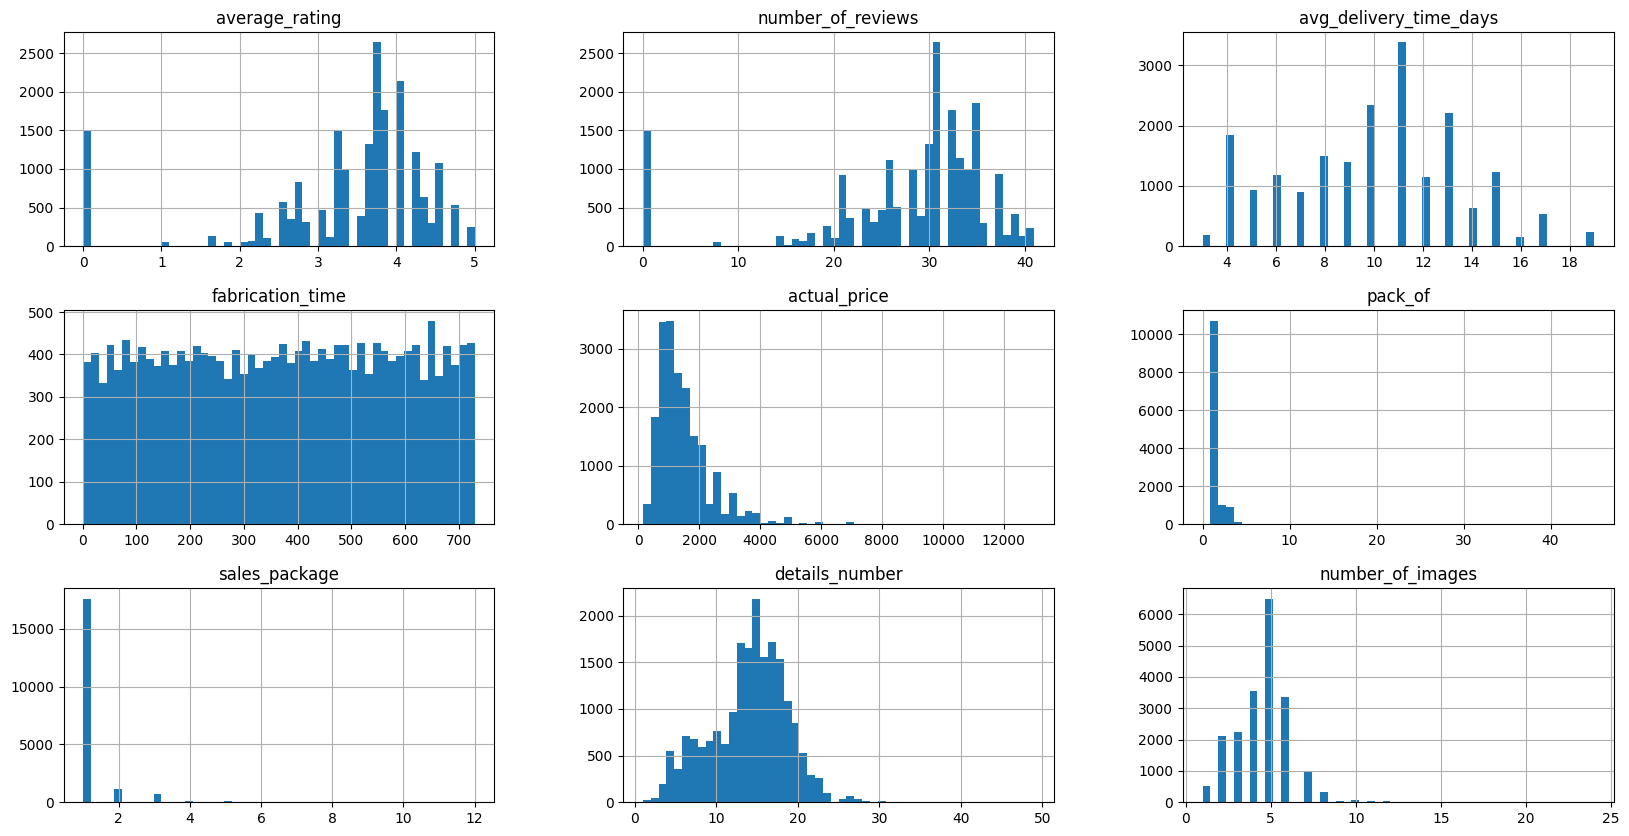

In [19]:
#Plot Histograms
num_ft.hist(bins=50, figsize=(20,10));

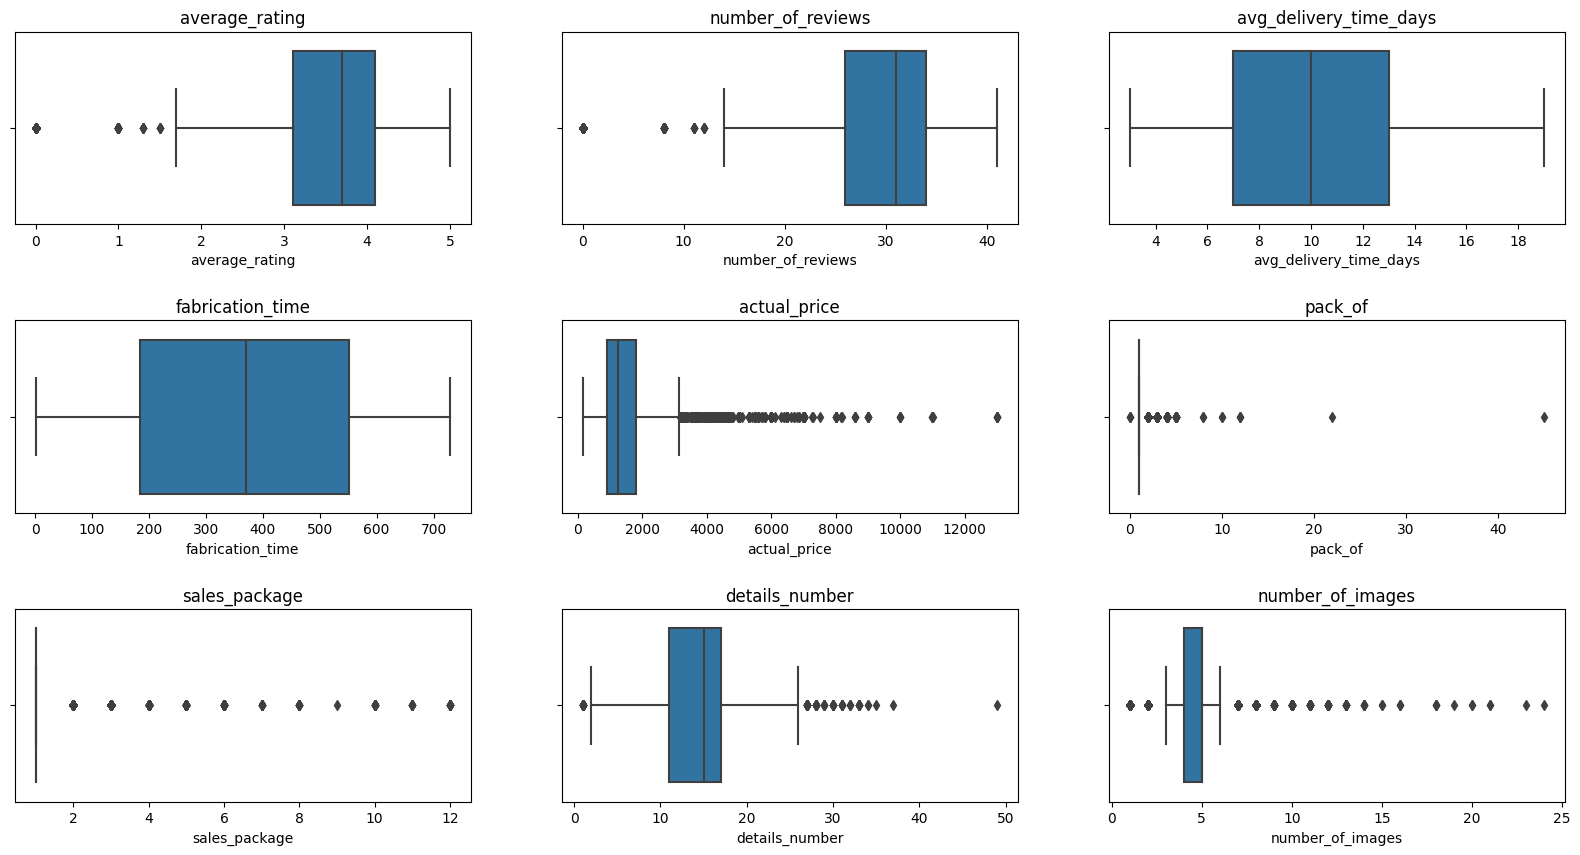

In [20]:
#Plot Boxplots
cols_plot = num_ft.columns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

#Find axes with Divmod
for i, column in enumerate(cols_plot):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    #Plot all Boxplots
    sns.boxplot(num_ft, x=column, ax=ax)
    ax.set_title(column)

### 1.9.2 Bivariate Analysis

**Hypothesis Definition**

1. Products with basic colors are in greater quantities **-> True**
2. Products with basic colors have the lowest price on average **-> False**
3. Cotton products priced below average **-> True**
4. Products with a solid standard are priced below average **-> False**
5. Clothing categories have the highest prices on average **-> True**
---
In Portuguese Language:

1. Produtos com cores básicas estão em maiores quantidades **-> Verdadeira**
2. Produtos com cores básicas possuem em média o menor preço **-> Falsa**
3. Produtos de algodão possuem preços abaixo da média **-> Verdadeira**
4. Produtos com padrão sólido possuem preço abaixo da média **-> Falsa**
5. Categorias de vestuário possuem em média os maiores preços **-> Verdadeira**

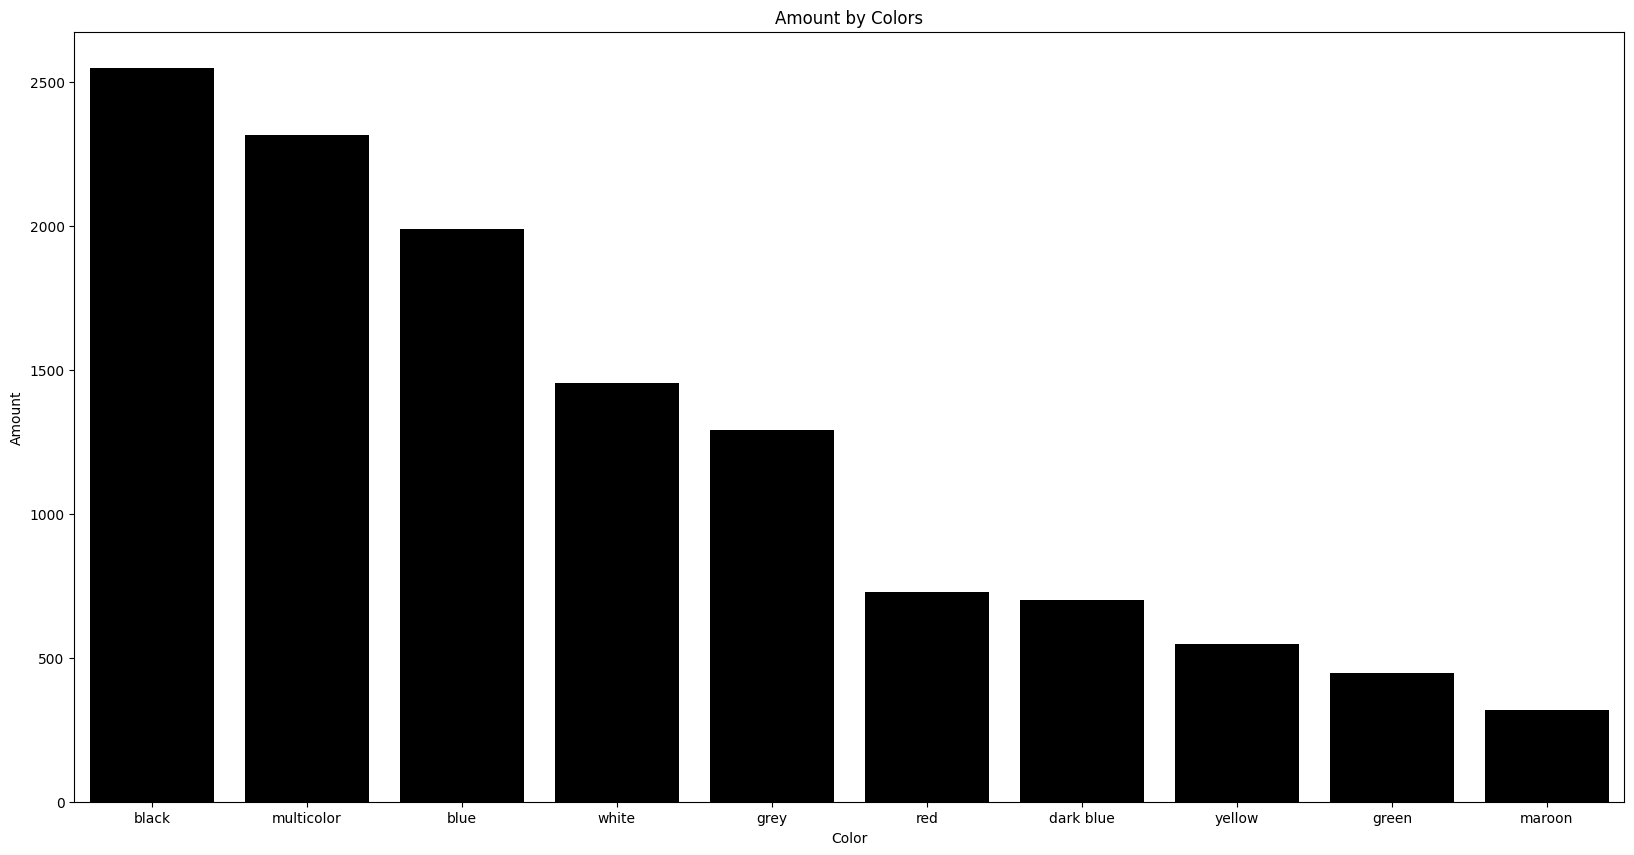

In [21]:
#H1 - Products with basic colors are in greater quantities > True
df_aux = df.loc[:, ['_id', 'color']].groupby('color').count().sort_values(by='_id', ascending=False).reset_index()

#Filter main colors
colors = ((df['color'] == 'black') |
          (df['color'] == 'multicolor') |
          (df['color'] == 'blue') | 
          (df['color'] == 'white')  | 
          (df['color'] == 'grey')|
          (df['color'] == 'red')|
          (df['color'] == 'dark blue')|
          (df['color'] == 'yellow')|
          (df['color'] == 'green')|
          (df['color'] == 'maroon'))

df_aux2 = df.loc[colors, ['_id', 'color']].groupby('color').count().sort_values(by='_id', ascending=False).reset_index()

#Plot results
plt.figure(figsize=(20,10))
sns.barplot(df_aux2, x='color', y='_id', color='black')
plt.title('Amount by Colors')
plt.xlabel('Color')
plt.ylabel('Amount');

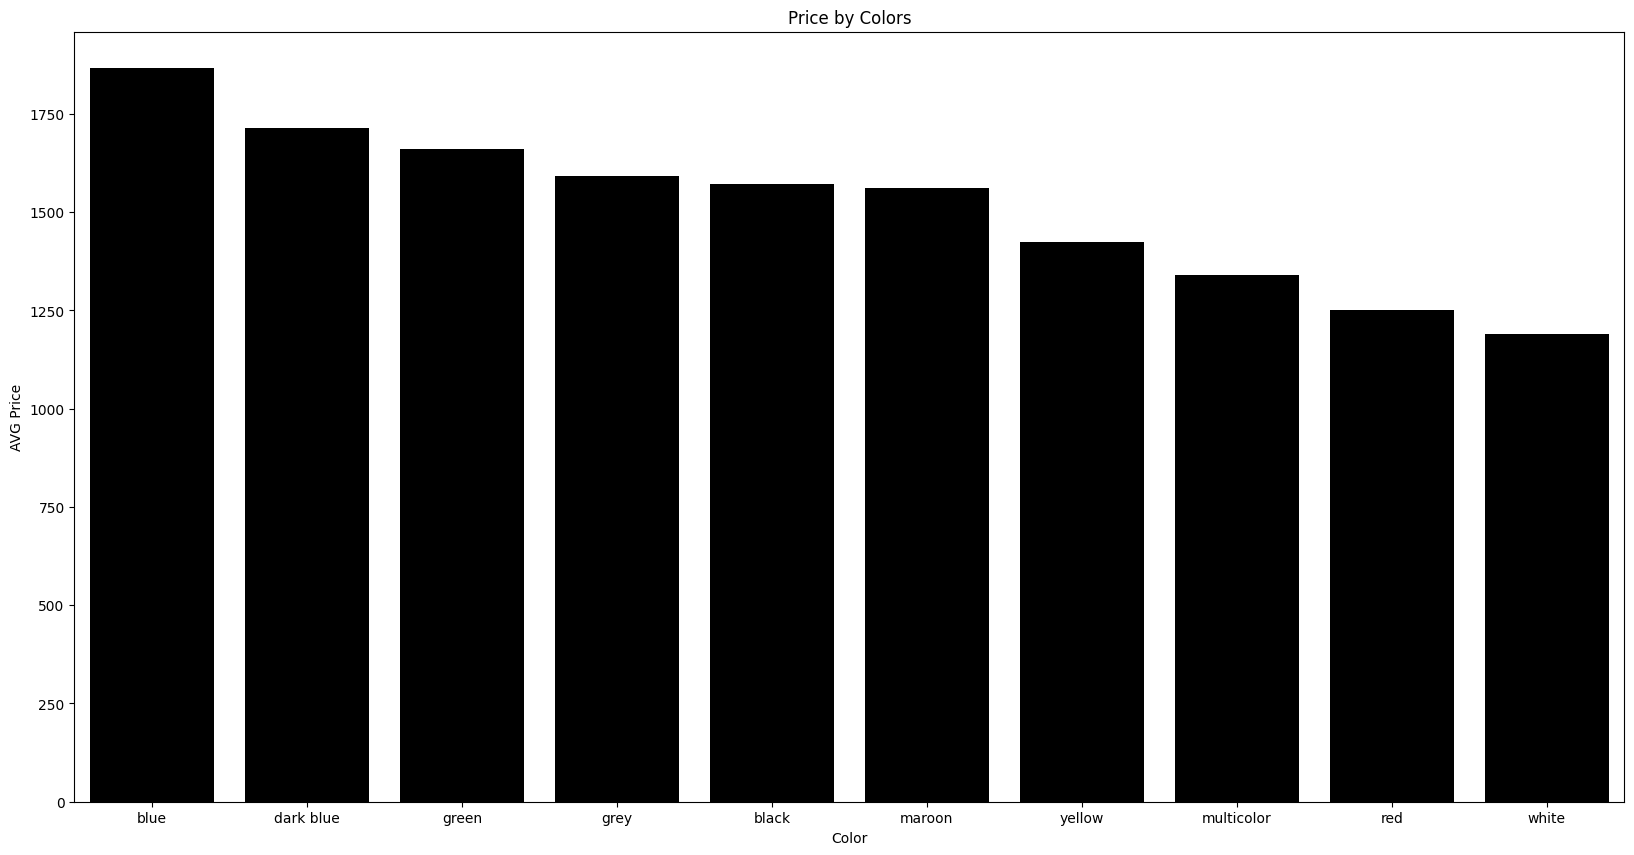

In [22]:
#H2 - Products with basic colors have the lowest price on average > False
df_aux = df.loc[:, ['actual_price', 'color']].groupby('color').mean().sort_values(by='actual_price', ascending=False).reset_index()

#Filter main colors
colors = ((df['color'] == 'black') |
          (df['color'] == 'multicolor') |
          (df['color'] == 'blue') | 
          (df['color'] == 'white')  | 
          (df['color'] == 'grey')|
          (df['color'] == 'red')|
          (df['color'] == 'dark blue')|
          (df['color'] == 'yellow')|
          (df['color'] == 'green')|
          (df['color'] == 'maroon'))

df_aux = df.loc[colors, ['actual_price', 'color']].groupby('color').mean().sort_values(by='actual_price', ascending=False).reset_index()

#Plot results
plt.figure(figsize=(20,10))
sns.barplot(df_aux, x='color', y='actual_price', color='black')
plt.title('Price by Colors')
plt.xlabel('Color')
plt.ylabel('AVG Price');

AVG Price: 1480.98
AVG Cotton Price: 1403.19


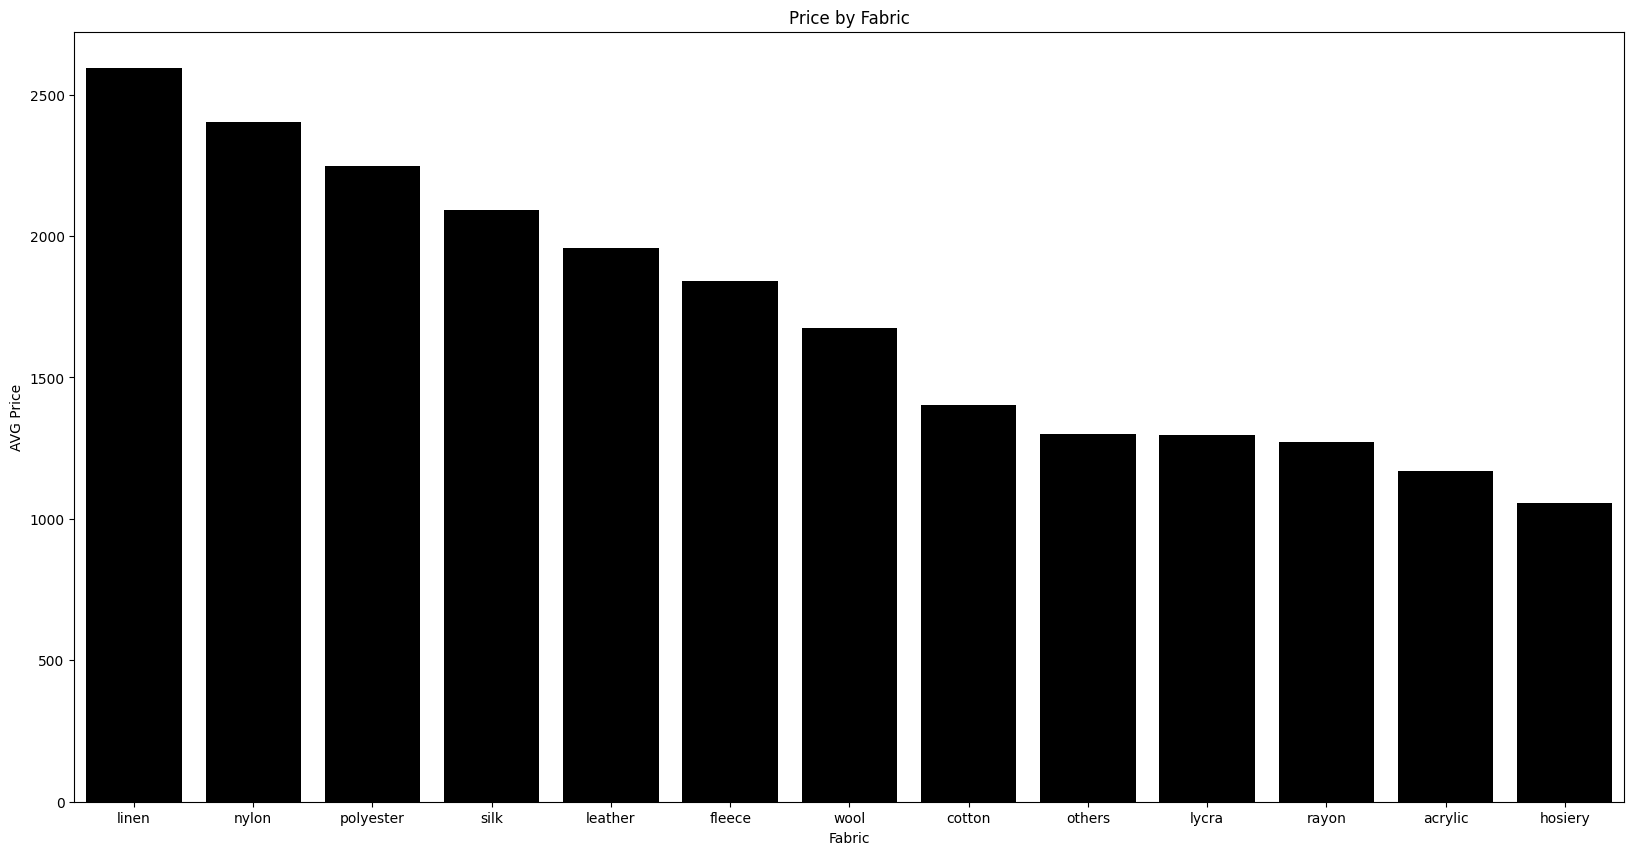

In [23]:
#H3 - Cotton products priced below average > True
mean_prc = df['actual_price'].mean()
print('AVG Price: {:.2f}'.format(mean_prc))
mean_prc_cotton = df.loc[df['fabric'] == 'cotton', ['actual_price']].mean()
print('AVG Cotton Price: {:.2f}'.format(mean_prc_cotton['actual_price']))

df_aux = df.loc[:, ['actual_price', 'fabric']].groupby('fabric').mean().sort_values(by='actual_price', ascending=False).reset_index()

#Plot results
plt.figure(figsize=(20,10))
sns.barplot(df_aux, x='fabric', y='actual_price', color='black')
plt.title('Price by Fabric')
plt.xlabel('Fabric')
plt.ylabel('AVG Price');

AVG Price: 1480.98
AVG Pattern Solid Price: 1628.70


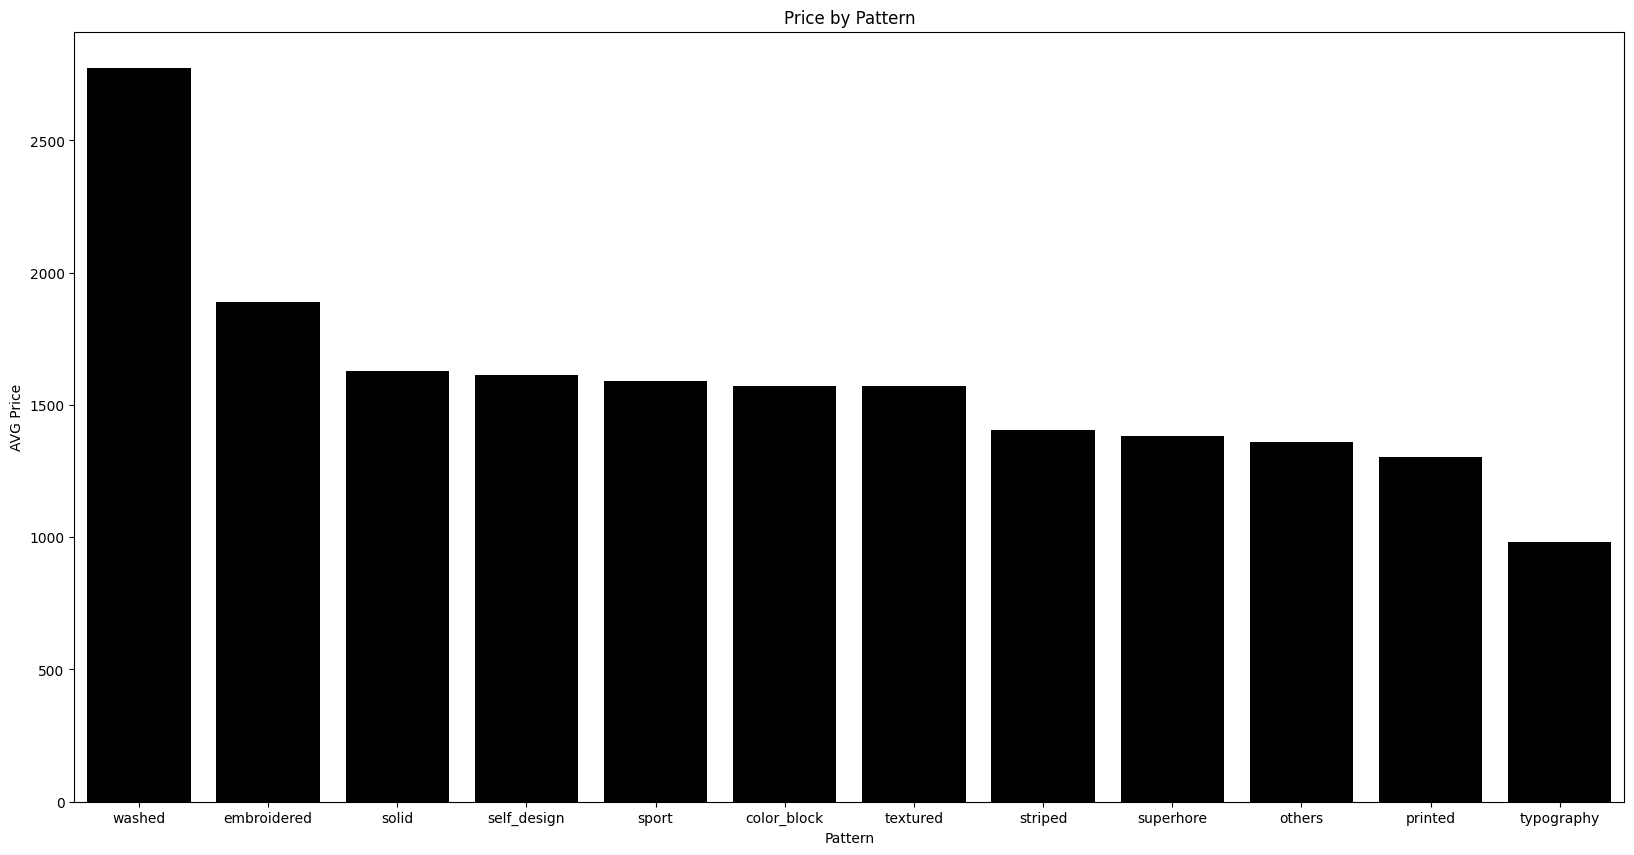

In [24]:
#H4 - Products with a solid standard are priced below average > False
mean_prc = df['actual_price'].mean()
print('AVG Price: {:.2f}'.format(mean_prc))
mean_prc_cotton = df.loc[df['pattern'] == 'solid', ['actual_price']].mean()
print('AVG Pattern Solid Price: {:.2f}'.format(mean_prc_cotton['actual_price']))

df_aux = df.loc[:, ['actual_price', 'pattern']].groupby('pattern').mean().sort_values(by='actual_price', ascending=False).reset_index()

#Plot results
plt.figure(figsize=(20,10))
sns.barplot(df_aux, x='pattern', y='actual_price', color='black')
plt.title('Price by Pattern')
plt.xlabel('Pattern')
plt.ylabel('AVG Price');

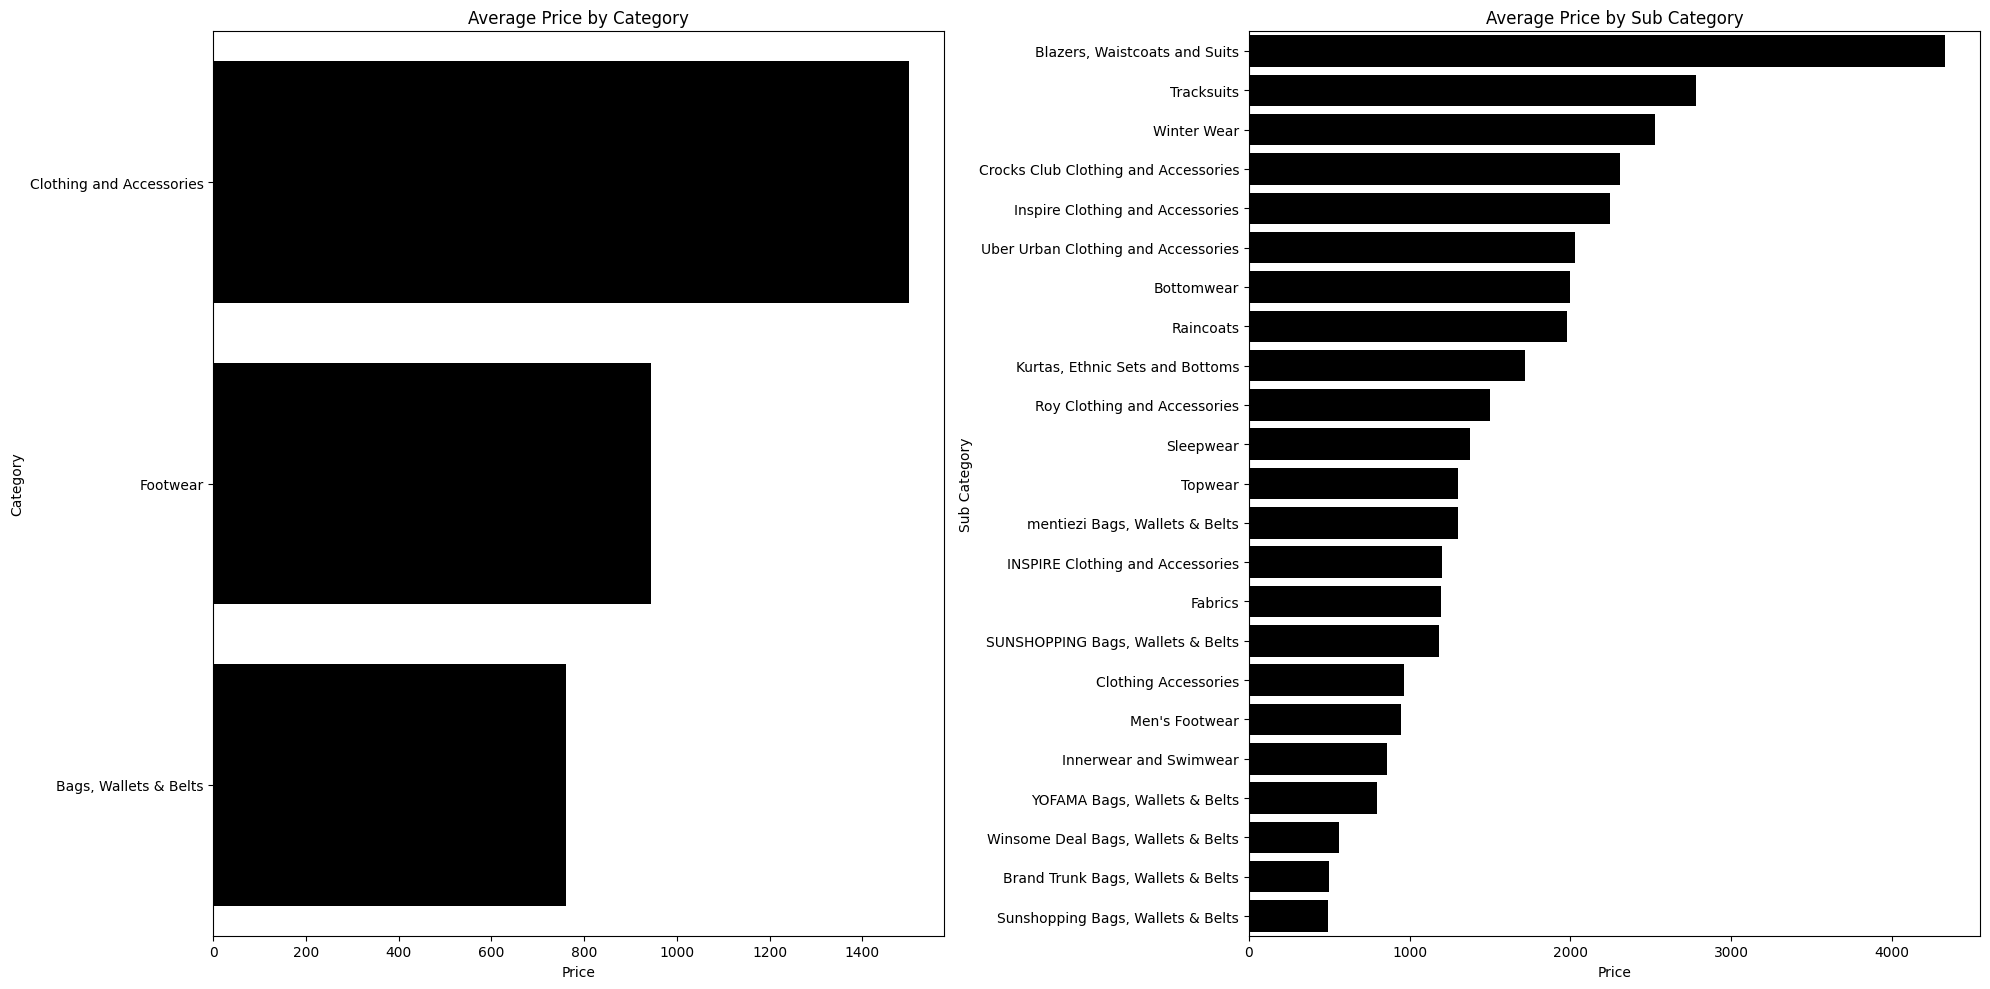

In [25]:
#H5 - Clothing categories have the highest prices on average > True
plt.figure(figsize=(20,10))

#Category
plt.subplot(1,2,1)
df_aux = df.loc[:, ['actual_price', 'category']].groupby(['category']).mean().sort_values(by='actual_price', ascending=False).reset_index()
sns.barplot(df_aux, x='actual_price', y='category', orient='horizontal', color='black')
plt.title('Average Price by Category')
plt.xlabel("Price")
plt.ylabel("Category")

#Subcategory
plt.subplot(1,2,2)
df_aux2 = df.loc[:, ['actual_price', 'category', 'sub_category']].groupby(['sub_category']).mean().sort_values(by='actual_price', ascending=False).reset_index()
sns.barplot(df_aux2, x='actual_price', y='sub_category', orient='horizontal', color='black')
plt.title('Average Price by Sub Category')
plt.xlabel("Price")
plt.ylabel("Sub Category")

plt.tight_layout();

### 1.9.3 Multivariate Analysis

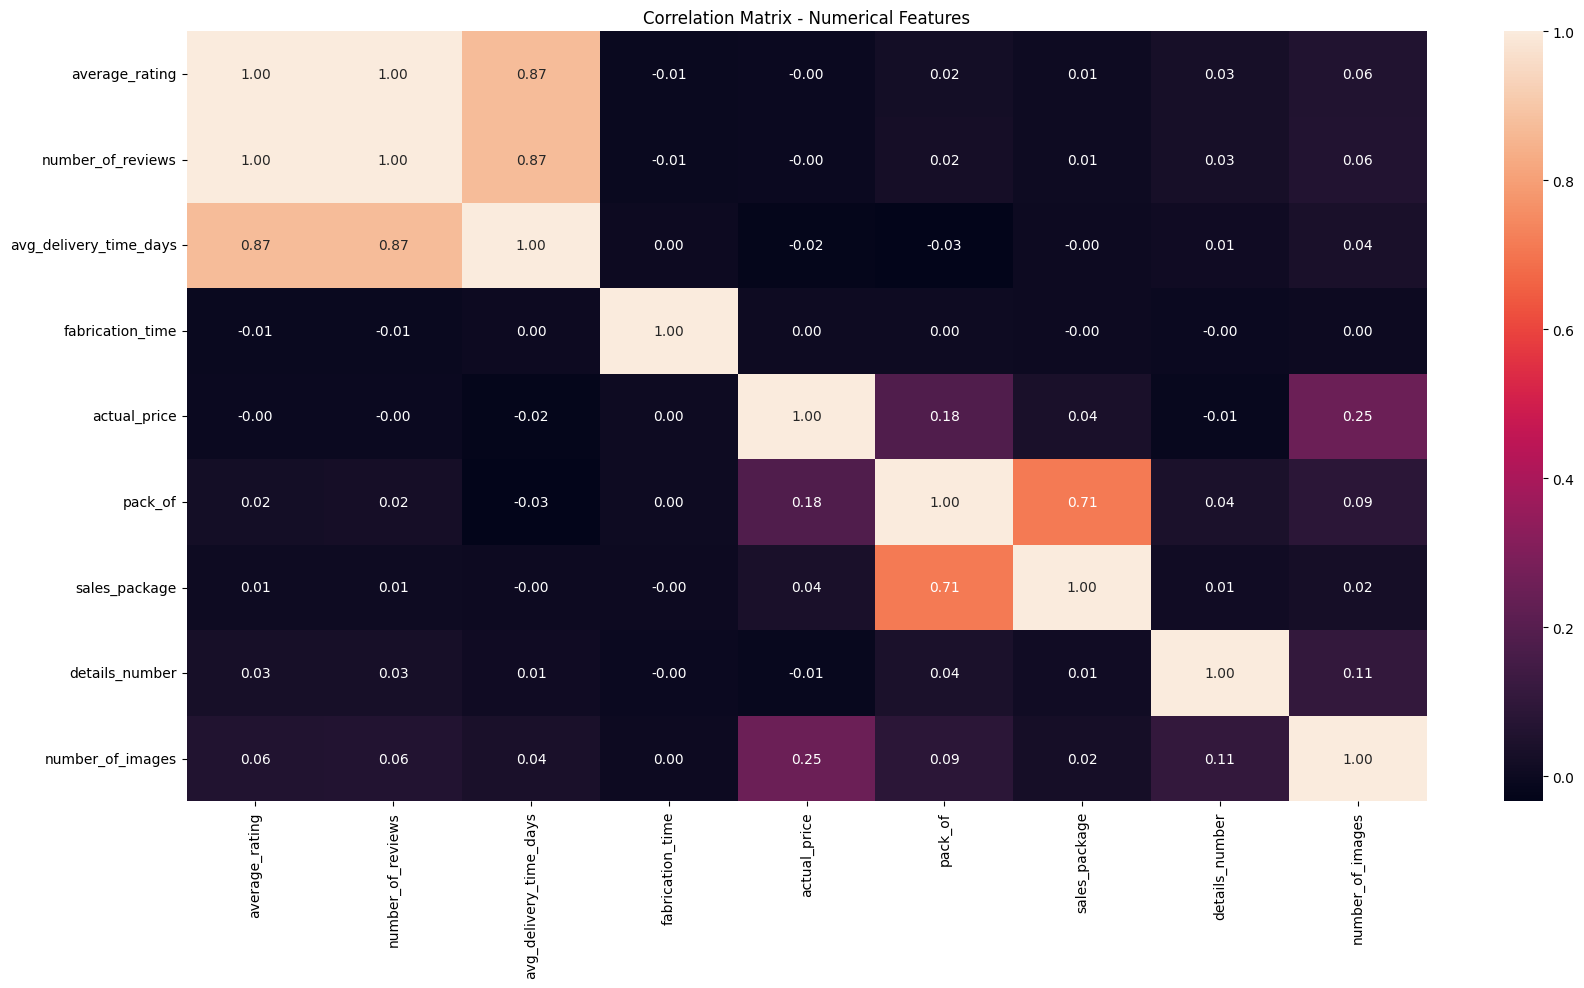

In [26]:
#Correlation Matrix of Numerical Features
plt.figure(figsize=(20,10))
correlation_num = num_ft.corr(method='pearson')
sns.heatmap(correlation_num, annot=True, fmt='.2f')
plt.title("Correlation Matrix - Numerical Features");

In [27]:
#Setting categorical columns for Cramer's V application
df_cramer = df.loc[:,['brand', 'category', 'crawled_at', 'description', 'out_of_stock',
                      'pid', 'product_details', 'seller', 'sub_category', 'title',
                      'reversible', 'size', 'fabric', 'pattern', 'neck_type', 'sleeve',
                      'suitable_for', 'fabric_care', 'color', 'fit', 'ideal_for',
                      'country_of_origin']]

num_vars = len(df_cramer.columns)
corr_matrix = np.zeros((num_vars, num_vars))

#Application of Cramer's V
for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            corr = cramers_v(df_cramer.iloc[:, i], df_cramer.iloc[:, j])
            corr_matrix[i, j] = corr

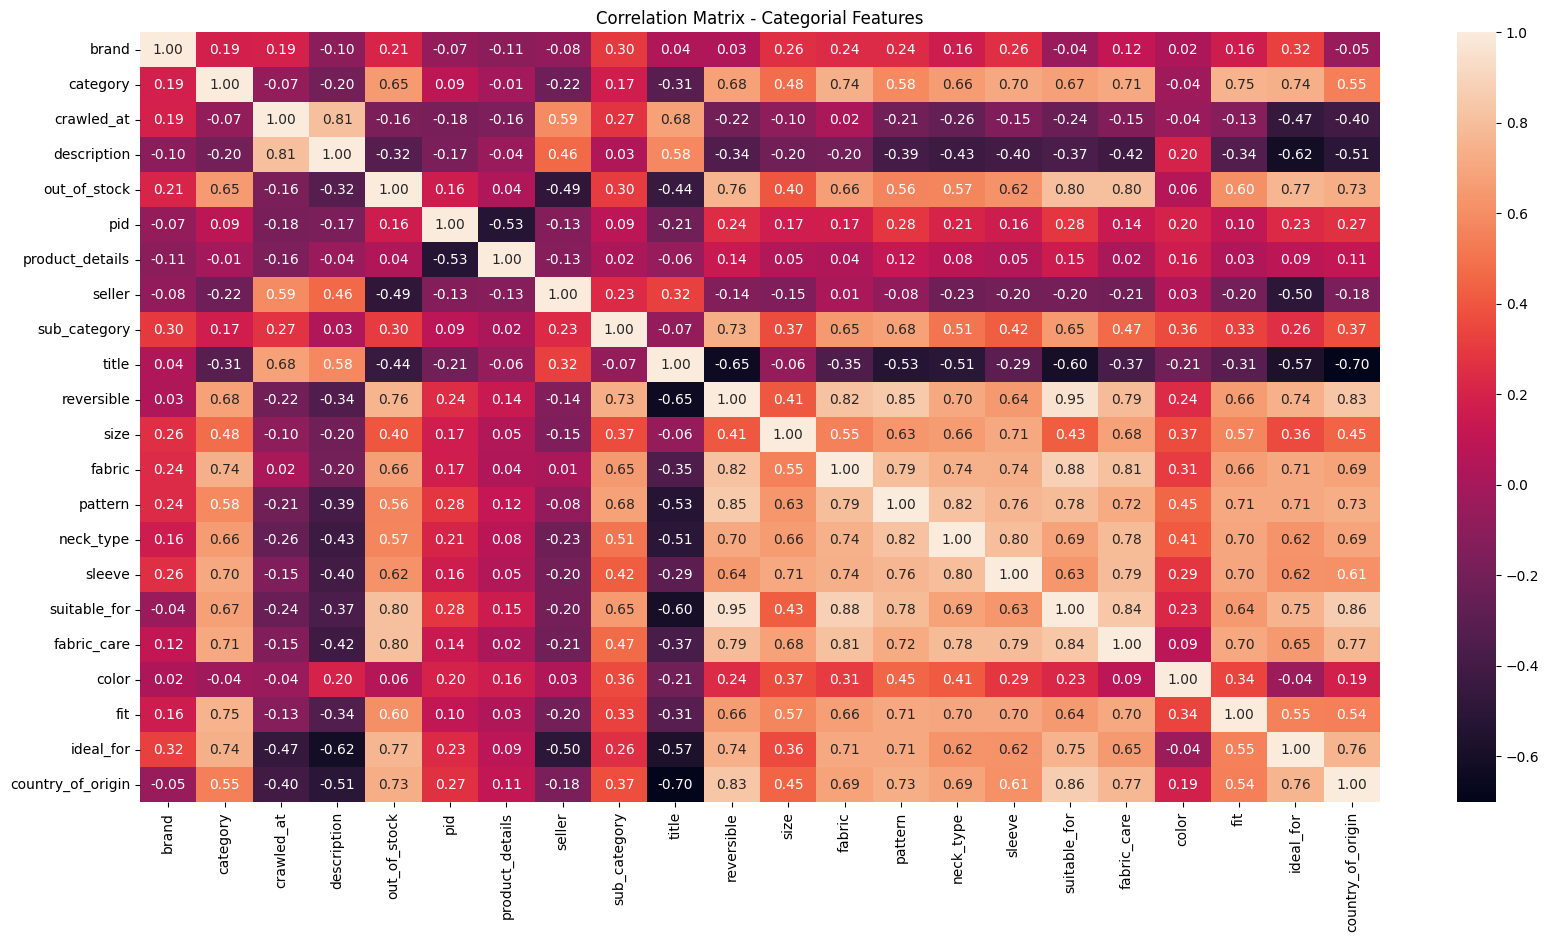

In [28]:
#Plot Categorial Correlation Matrix
plt.figure(figsize=(20,10))

corr_df = pd.DataFrame(corr_matrix, columns=df_cramer.columns, index=df_cramer.columns)
sns.heatmap(corr_df.corr(), annot=True, fmt='.2f')
plt.title("Correlation Matrix - Categorial Features");

# 2.0. Feature Engineering

In [29]:
#Dataframe Feature Engineering
#Dataset backup
df1 = df.copy()
df1_x = df_x.copy()

In [30]:
#Check dataset types
df1.dtypes

_id                        object
average_rating            float64
number_of_reviews           int64
brand                      object
category                   object
crawled_at                 object
description                object
out_of_stock                 bool
avg_delivery_time_days      int64
pid                        object
product_details            object
seller                     object
sub_category               object
fabrication_time            int64
title                      object
actual_price              float64
reversible                 object
size                       object
fabric                     object
pattern                    object
neck_type                  object
sleeve                     object
suitable_for               object
fabric_care                object
pack_of                   float64
color                      object
fit                        object
ideal_for                  object
sales_package               int64
country_of_ori

In [31]:
#Check dataset columns
df.columns

Index(['_id', 'average_rating', 'number_of_reviews', 'brand', 'category',
       'crawled_at', 'description', 'out_of_stock', 'avg_delivery_time_days',
       'pid', 'product_details', 'seller', 'sub_category', 'fabrication_time',
       'title', 'actual_price', 'reversible', 'size', 'fabric', 'pattern',
       'neck_type', 'sleeve', 'suitable_for', 'fabric_care', 'pack_of',
       'color', 'fit', 'ideal_for', 'sales_package', 'country_of_origin',
       'details_number', 'number_of_images'],
      dtype='object')

In [32]:
#Apply Feature Engineering
df1 = feature_eng(df1)
df1_x = feature_eng(df1_x)

In [33]:
#Checking number of rows and columns of the dataframe after Feature Engineering
print('Train Rows: {}'.format(df1.shape[0]))
print('Train Cols: {}'.format(df1.shape[1]))

print('Test Rows: {}'.format(df1_x.shape[0]))
print('Test Cols: {}'.format(df1_x.shape[1]))

Train Rows: 19813
Train Cols: 32
Test Rows: 5600
Test Cols: 31


In [34]:
#Check train data types
df1.dtypes

_id                         int64
average_rating            float64
number_of_reviews           int64
brand                       int64
category                    int64
crawled_at                 object
description                object
out_of_stock                int64
avg_delivery_time_days      int64
pid                         int64
product_details            object
seller                      int64
sub_category                int64
fabrication_time            int64
title                       int64
actual_price              float64
reversible                  int64
size                        int64
fabric                      int64
pattern                     int64
neck_type                   int64
sleeve                      int64
suitable_for                int64
fabric_care                 int64
pack_of                   float64
color                       int64
fit                         int64
ideal_for                   int64
sales_package               int64
country_of_ori

# 3.0. Data Filtering

In [35]:
#Dataframe Filtering
df2 = df1.copy()
df2_x = df1_x.copy()

In [36]:
#No Filter necessary

In [37]:
#Check train data types
df2.dtypes

_id                         int64
average_rating            float64
number_of_reviews           int64
brand                       int64
category                    int64
crawled_at                 object
description                object
out_of_stock                int64
avg_delivery_time_days      int64
pid                         int64
product_details            object
seller                      int64
sub_category                int64
fabrication_time            int64
title                       int64
actual_price              float64
reversible                  int64
size                        int64
fabric                      int64
pattern                     int64
neck_type                   int64
sleeve                      int64
suitable_for                int64
fabric_care                 int64
pack_of                   float64
color                       int64
fit                         int64
ideal_for                   int64
sales_package               int64
country_of_ori

In [38]:
#Check columns after Feature Engineering
df2.columns.unique()

Index(['_id', 'average_rating', 'number_of_reviews', 'brand', 'category',
       'crawled_at', 'description', 'out_of_stock', 'avg_delivery_time_days',
       'pid', 'product_details', 'seller', 'sub_category', 'fabrication_time',
       'title', 'actual_price', 'reversible', 'size', 'fabric', 'pattern',
       'neck_type', 'sleeve', 'suitable_for', 'fabric_care', 'pack_of',
       'color', 'fit', 'ideal_for', 'sales_package', 'country_of_origin',
       'details_number', 'number_of_images'],
      dtype='object')

# 4.0. Data Preparation 

In [39]:
#Dataframe Preparation for Machine Learning Algorithms
df3 = df2.copy()
df3_x = df2_x.copy()

In [40]:
#Setting train/test data to algorithm application
df3 = feature_opt(df3)
df3_x = feature_opt(df3_x)

In [41]:
#Check train dataset types after Feature Optimization
df3.dtypes

_id                       float64
average_rating            float64
number_of_reviews           int64
brand                     float64
category                  float64
crawled_at                 object
description                object
out_of_stock                int64
avg_delivery_time_days    float64
pid                         int64
product_details            object
seller                    float64
sub_category              float64
fabrication_time          float64
title                     float64
actual_price              float64
reversible                float64
size                      float64
fabric                    float64
pattern                   float64
neck_type                 float64
sleeve                    float64
suitable_for              float64
fabric_care               float64
pack_of                   float64
color                     float64
fit                       float64
ideal_for                 float64
sales_package               int64
country_of_ori

# 5.0. Feature Selection 

In [42]:
#Selecting Features for Machine Learning Algorithms Application
cols_drop = ['crawled_at', 'description', 'product_details']
df3 = df3.drop(cols_drop, axis=1)
df3_x = df3_x.drop(cols_drop, axis=1)

In [43]:
#Check train dataset
df3

,_id,average_rating,number_of_reviews,brand,category,out_of_stock,avg_delivery_time_days,pid,seller,sub_category,...,suitable_for,fabric_care,pack_of,color,fit,ideal_for,sales_package,country_of_origin,details_number,number_of_images
0,-0.34,0.64,26,-0.59,0.50,0,0.31,470,0.79,-1.00,...,1.00,0.83,1.00,0.27,0.00,1.00,1,1.00,6,5
1,0.63,0.80,33,0.70,0.50,0,0.56,16647,-0.57,0.00,...,0.75,0.17,1.00,0.73,0.50,0.00,1,1.00,16,2
2,-0.05,0.78,32,-0.49,0.50,0,0.50,8282,-0.75,0.44,...,0.75,0.50,0.00,0.98,0.00,1.00,1,1.00,14,5
3,-0.96,0.76,31,-0.42,0.50,0,0.50,12627,-0.35,0.00,...,0.75,0.33,2.00,0.63,0.50,0.00,2,1.00,18,5
4,0.67,0.48,20,0.20,0.50,0,0.12,16282,0.27,0.00,...,0.75,1.00,1.00,0.92,0.50,0.00,1,0.40,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23303,1.00,0.50,21,-0.60,0.50,0,0.12,15492,0.44,0.00,...,0.75,0.33,1.00,0.20,1.00,0.00,1,0.40,17,5
23304,0.76,0.82,34,0.82,0.50,0,0.62,9619,0.57,0.44,...,1.00,0.83,0.00,1.00,0.00,0.00,1,0.40,11,4
23306,-0.67,0.00,0,-0.34,0.50,0,0.06,1873,-0.30,-0.78,...,1.00,1.00,0.00,0.15,0.00,1.00,2,0.40,16,5
23307,0.43,0.00,0,0.62,0.50,0,0.06,15935,-0.09,0.00,...,0.75,0.33,1.00,0.92,0.50,0.00,1,0.40,17,6


In [44]:
#Check test dataset
df3_x

,_id,average_rating,number_of_reviews,brand,category,out_of_stock,avg_delivery_time_days,pid,seller,sub_category,...,suitable_for,fabric_care,pack_of,color,fit,ideal_for,sales_package,country_of_origin,details_number,number_of_images
0,-0.58,0.96,40,0.00,0.50,0,0.88,1412,-0.20,0.00,...,0.75,0.33,1.00,0.90,1.00,1.00,1,0.38,15,4
1,-0.34,0.74,31,0.56,0.50,0,0.44,2914,-0.22,-1.56,...,0.75,0.33,1.00,0.19,1.00,1.00,1,0.38,14,5
2,0.08,0.64,26,0.96,0.50,0,0.31,575,0.71,-1.22,...,1.00,1.00,0.00,0.34,0.00,0.00,1,0.38,15,4
3,0.07,0.72,30,0.56,0.50,0,0.44,190,-0.22,-1.67,...,1.00,0.83,1.00,0.13,0.00,1.00,1,0.38,11,5
4,0.21,0.50,21,-0.52,0.50,0,0.12,1646,0.44,0.00,...,0.75,0.33,1.00,0.19,1.00,1.00,1,0.38,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,-0.06,0.68,28,-0.80,0.50,0,0.38,3692,-0.87,0.00,...,0.75,0.83,2.00,0.61,0.50,0.00,2,1.00,18,5
5596,-0.23,0.84,35,0.94,0.50,0,0.62,466,0.63,-0.78,...,1.00,0.83,0.00,1.00,0.00,0.00,1,1.00,5,5
5597,0.19,0.00,0,-0.14,0.50,0,0.06,194,-0.13,-1.67,...,1.00,0.83,1.00,0.40,0.00,1.00,1,0.38,14,5
5598,0.19,0.66,27,-0.34,0.50,0,0.31,3871,-0.36,0.00,...,0.75,1.00,1.00,0.70,0.50,0.00,1,1.00,14,4


In [45]:
#Split train dataset into features and target
X = df3.drop(['actual_price'], axis=1)
y = df3['actual_price']

In [46]:
#Split train dataset into train and test for valuation
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

## 5.1. Boruta

In [47]:
##Dataframe Feature Selection for Machine Learning Algorithms
##Define Training and Test datasets for Boruta
#X_train_n = X.values
#y_train_n = y.values.ravel()
#
##Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)
#
##Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)
#
##Include columns to list
#cols_sel = boruta.support_.tolist()
#
##Best features
#cols_sel_boruta = X.iloc[:, cols_sel].columns.tolist()
#cols_sel_boruta

Columns selected by Boruta Boruta:

['average_rating', 'number_of_reviews', 'brand', 'pid', 'seller', 'sub_category', 'title', 'fabric', 'sleeve', 'fabric_care', 'pack_of', 'color', 'details_number', 'number_of_images']


# 6.0. Machine Learning Model

## 6.1. Gradient Boost

In [48]:
#Model Definition
grb = GradientBoostingRegressor(learning_rate=0.1, max_depth=3,
                                n_estimators=100, verbose=0,)

#Model Training
grb.fit(X_train, y_train)

#Model Prediction
yhat_grb = grb.predict(X_val)

### 6.1.1. Performance

In [49]:
#Show metrics of performance
mape_grb = mape(y_val, yhat_grb)
smape_grb = smape(y_val, yhat_grb)

#Print of performance
print('MAPE: {:.5f}'.format(mape_grb))
print('SMAPE: {:.5f}'.format(smape_grb))

MAPE: 0.26462
SMAPE: 0.22804


## 6.2. Random Forest Regressor

In [50]:
#Model Definition
rf = RandomForestRegressor(random_state=42)

#Model Training
rf.fit(X_train, y_train)

#Model Prediction
yhat_rf= rf.predict(X_val)

### 6.2.1. Performance

In [51]:
#Show metrics of performance
mape_rf = mape(y_val, yhat_rf)
smape_rf = smape(y_val, yhat_rf)

#Print of performance
print('MAPE: {:.5f}'.format(mape_rf))
print('SMAPE: {:.5f}'.format(smape_rf))

MAPE: 0.11218
SMAPE: 0.09857


## 6.3. LGBM Regressor

In [52]:
#Model Definition
lgb = LGBMRegressor(n_estimators=1000, max_depth=10)

#Model Training
lgb.fit(X_train, y_train)

#Model Prediction
yhat_lgb = lgb.predict(X_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1973
[LightGBM] [Info] Number of data points in the train set: 15850, number of used features: 28
[LightGBM] [Info] Start training from score 1481.507256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

### 6.3.1. Performance

In [53]:
#Show metrics of performance
mape_lgb = mape(y_val, yhat_lgb)
smape_lgb = smape(y_val, yhat_lgb)

#Print of performance
print('MAPE: {:.5f}'.format(mape_lgb))
print('SMAPE: {:.5f}'.format(smape_lgb))

MAPE: 0.14086
SMAPE: 0.12863


## 6.4. Voting Regressor (Ensemble)

In [54]:
#Merge data to compare
#Model Definition
v_reg = VotingRegressor( estimators=[('GRB', grb),
                                     ('RF', rf),
                                     ('LGBM', lgb)])

#Model Training
v_reg.fit(X_train, y_train)

#Model Prediction
yhat_en = v_reg.predict(X_val)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1973
[LightGBM] [Info] Number of data points in the train set: 15850, number of used features: 28
[LightGBM] [Info] Start training from score 1481.507256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

### 6.4.1. Performance

In [55]:
#Show metrics of performance
mape_en = mape(y_val, yhat_en)
smape_en = smape(y_val, yhat_en)

#Print of performance
print('MAPE: {:.5f}'.format(mape_en))
print('SMAPE: {:.5f}'.format(smape_en))

MAPE: 0.15764
SMAPE: 0.14067


# 7.0. Model Application to Test Data

In [56]:
#Model Test Prediction
yhat_grb_x = grb.predict(df3_x)

yhat_rf_x = rf.predict(df3_x)

yhat_lgb_x = lgb.predict(df3_x)

yhat_en_x = v_reg.predict(df3_x)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


# 8.0. Export CSV

In [57]:
#Prepare data to export GRB
df3_x['actual_price'] = yhat_grb_x

#Dataframe for export
submission_grb = pd.concat([df_x['pid'], pd.Series(yhat_grb_x)], axis = 1).rename(columns = {0: 'actual_price'})
submission_grb

,pid,actual_price
0,SHTFDYZGEXPED7YS,2239.35
1,TROFM47EVWRYK7ZU,2026.38
2,FABFZAMPGDW3BKGX,1504.96
3,BZRFNMGPNBQTYHMG,2710.38
4,SHTFV5G6PZDQZEVZ,2251.12
...,...,...
5595,TSHFHHYFYUDABZAV,1739.59
5596,DHTFZ3WE9XGWEH3H,896.45
5597,BZRFZQC6NXA5QV7F,2958.40
5598,TSHFMKUGFR6HSP7E,1302.64


In [58]:
#Prepare data to export RF
df3_x['actual_price'] = yhat_rf_x

#Dataframe for export
submission_rf = pd.concat([df_x['pid'], pd.Series(yhat_rf_x)], axis = 1).rename(columns = {0: 'actual_price'})
submission_rf

,pid,actual_price
0,SHTFDYZGEXPED7YS,1929.73
1,TROFM47EVWRYK7ZU,1790.84
2,FABFZAMPGDW3BKGX,1361.20
3,BZRFNMGPNBQTYHMG,6356.00
4,SHTFV5G6PZDQZEVZ,1784.57
...,...,...
5595,TSHFHHYFYUDABZAV,1673.90
5596,DHTFZ3WE9XGWEH3H,1167.76
5597,BZRFZQC6NXA5QV7F,7494.00
5598,TSHFMKUGFR6HSP7E,1374.14


In [59]:
#Prepare data to export LGBM
df3_x['actual_price'] = yhat_lgb_x

#Dataframe for export
submission_lgb = pd.concat([df_x['pid'], pd.Series(yhat_lgb_x)], axis = 1).rename(columns = {0: 'actual_price'})
submission_lgb

,pid,actual_price
0,SHTFDYZGEXPED7YS,1507.19
1,TROFM47EVWRYK7ZU,1235.07
2,FABFZAMPGDW3BKGX,1525.15
3,BZRFNMGPNBQTYHMG,3694.74
4,SHTFV5G6PZDQZEVZ,1725.97
...,...,...
5595,TSHFHHYFYUDABZAV,1611.32
5596,DHTFZ3WE9XGWEH3H,1480.38
5597,BZRFZQC6NXA5QV7F,4707.45
5598,TSHFMKUGFR6HSP7E,1007.98


In [60]:
#Prepare data to export Ensemble
df3_x['actual_price'] = yhat_en_x

#Dataframe for export
submission_en = pd.concat([df_x['pid'], pd.Series(yhat_en_x)], axis = 1).rename(columns = {0: 'actual_price'})
submission_en

,pid,actual_price
0,SHTFDYZGEXPED7YS,1892.09
1,TROFM47EVWRYK7ZU,1684.10
2,FABFZAMPGDW3BKGX,1463.77
3,BZRFNMGPNBQTYHMG,4253.71
4,SHTFV5G6PZDQZEVZ,1920.55
...,...,...
5595,TSHFHHYFYUDABZAV,1674.94
5596,DHTFZ3WE9XGWEH3H,1204.24
5597,BZRFZQC6NXA5QV7F,5053.29
5598,TSHFMKUGFR6HSP7E,1228.26


In [61]:
#Check General Performance for choose the right model to export
print('SMAPE GRBOOST: {:.2f}%'.format(smape_grb*100))
print('SMAPE RF: {:.2f}%'.format(smape_rf*100))
print('SMAPE LGBM: {:.2f}%'.format(smape_lgb*100))
print('SMAPE ENSEMBLE: {:.2f}%'.format(smape_en*100))

SMAPE GRBOOST: 22.80%
SMAPE RF: 9.86%
SMAPE LGBM: 12.86%
SMAPE ENSEMBLE: 14.07%


In [62]:
#Export data
submission_rf.to_csv('submission.csv', index=False)